<a href="https://colab.research.google.com/github/harihardiyan/tdgl-gl-benchmark/blob/main/notebooks/Phase_Diagram_(H_vs_T).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/harihardiyan/tdgl-gl-benchmark.git
%cd tdgl-gl-benchmark

!pip install -r requirements.txt --quiet

Cloning into 'tdgl-gl-benchmark'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 64 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (64/64), 666.16 KiB | 3.83 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/tdgl-gl-benchmark


In [2]:

from tdgl_core import (
    init_params_basic,
    init_state_random,
    tdgl_step,
    total_energy,
    to_complex,
)

from tdgl_core.observables import (
    detect_vortices_phase_winding,
)

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [ ]:

# Phase Diagram (H vs T)

We explore the TDGL phase diagram by scanning:
- External magnetic field H
- Temperature-like parameter T (implemented via alpha(T))

We measure:
- Energy
- Density variance indicator
- Vortex count

This produces a coarse phase diagram.

In [3]:

def set_temperature(params, T):
    # alpha(T) = alpha0 * (1 - T)
    alpha0 = 1.0
    new_alpha = alpha0 * (1.0 - T)
    return params.replace(alpha=new_alpha)

In [4]:

H_vals = jnp.linspace(0.00, 0.50, 10)
T_vals = jnp.linspace(0.00, 1.00, 10)

print("H grid:", H_vals)
print("T grid:", T_vals)

H grid: [0.         0.05555556 0.11111111 0.16666667 0.22222222 0.2777778
 0.33333334 0.3888889  0.44444445 0.5       ]
T grid: [0.         0.11111111 0.22222222 0.33333334 0.44444445 0.5555556
 0.6666667  0.7777778  0.8888889  1.        ]


In [5]:

energy_map = jnp.zeros((len(T_vals), len(H_vals)))
indicator_map = jnp.zeros((len(T_vals), len(H_vals)))
vortex_map = jnp.zeros((len(T_vals), len(H_vals)))

In [7]:

nx = ny = 64
steps = 1200
dt = 0.01

for i, T in enumerate(T_vals):
    for j, H in enumerate(H_vals):

        params = init_params_basic(nx=nx, ny=ny, B0=H)

        # Temperature update (direct assignment)
        alpha0 = 1.0
        params.alpha = alpha0 * (1.0 - T)

        state = init_state_random(params, noise=0.3)

        for _ in range(steps):
            state = tdgl_step(state, params, dt)

        psi = to_complex(state.psi)
        dens = jnp.abs(psi)**2

        E = total_energy(state, params)
        vort_mask = detect_vortices_phase_winding(psi)
        vort_count = jnp.sum(vort_mask == 1)

        energy_map = energy_map.at[i, j].set(E)
        indicator_map = indicator_map.at[i, j].set(jnp.var(dens))
        vortex_map = vortex_map.at[i, j].set(vort_count)

print("Phase scan complete.")

Phase scan complete.


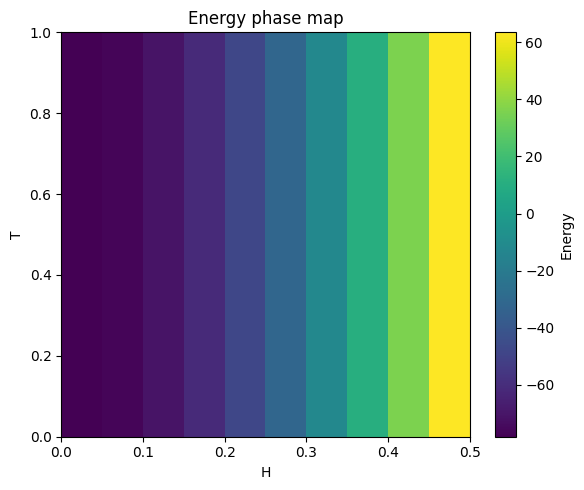

In [8]:

plt.figure(figsize=(6,5))
plt.imshow(energy_map, origin="lower",
           extent=[H_vals[0], H_vals[-1], T_vals[0], T_vals[-1]],
           aspect="auto", cmap="viridis")
plt.colorbar(label="Energy")
plt.xlabel("H")
plt.ylabel("T")
plt.title("Energy phase map")
plt.tight_layout()
plt.show()

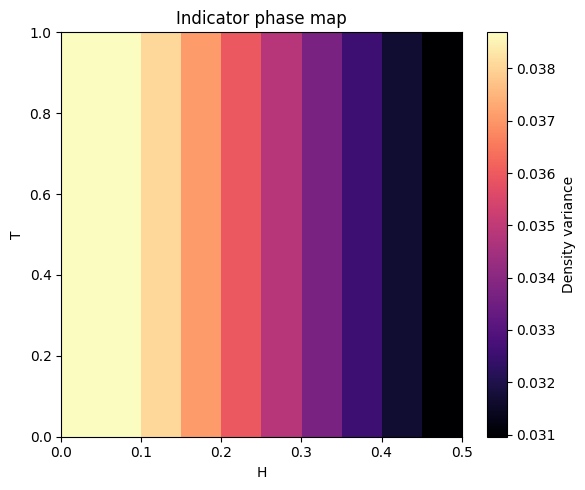

In [9]:

plt.figure(figsize=(6,5))
plt.imshow(indicator_map, origin="lower",
           extent=[H_vals[0], H_vals[-1], T_vals[0], T_vals[-1]],
           aspect="auto", cmap="magma")
plt.colorbar(label="Density variance")
plt.xlabel("H")
plt.ylabel("T")
plt.title("Indicator phase map")
plt.tight_layout()
plt.show()

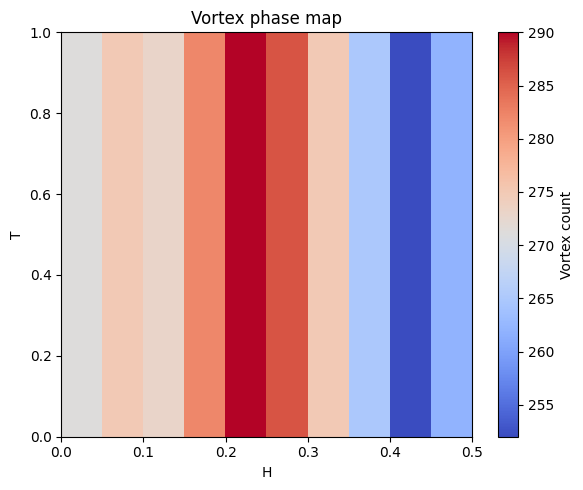

In [10]:

plt.figure(figsize=(6,5))
plt.imshow(vortex_map, origin="lower",
           extent=[H_vals[0], H_vals[-1], T_vals[0], T_vals[-1]],
           aspect="auto", cmap="coolwarm")
plt.colorbar(label="Vortex count")
plt.xlabel("H")
plt.ylabel("T")
plt.title("Vortex phase map")
plt.tight_layout()
plt.show()

In [11]:

print("=== Phase Diagram Summary ===")
print("H range:", H_vals)
print("T range:", T_vals)
print("Energy map shape:", energy_map.shape)
print("Indicator map shape:", indicator_map.shape)
print("Vortex map shape:", vortex_map.shape)

=== Phase Diagram Summary ===
H range: [0.         0.05555556 0.11111111 0.16666667 0.22222222 0.2777778
 0.33333334 0.3888889  0.44444445 0.5       ]
T range: [0.         0.11111111 0.22222222 0.33333334 0.44444445 0.5555556
 0.6666667  0.7777778  0.8888889  1.        ]
Energy map shape: (10, 10)
Indicator map shape: (10, 10)
Vortex map shape: (10, 10)
